# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
!pip install keras
!pip install opencv-python
!pip install tensorflow-cpu

以下のsolution関数のみ編集してください。

In [3]:
def solution(x_test_df, train_df):
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from keras.callbacks import EarlyStopping
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.utils import to_categorical
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau
    import cv2  # OpenCV をインポート
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Attention

    encoder = LabelEncoder()

    def augment_images(images, labels):
        '''
        訓練用のデータの array (3d array) を受け取り, 要素である 2d array を基に拡張された 2d array を 3d array に詰め直して返す関数。
        新たにデータ拡張手法を追加したい場合は、以下の operations に lamda 関数を追加することで可能である。
        '''
        operations = [
            # 実行されるデータ拡張手法
            lambda x: x,
            lambda x: cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE),
            lambda x: cv2.rotate(x, cv2.ROTATE_180),
            lambda x: cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE),
            lambda x: cv2.flip(x, 0),
            lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_CLOCKWISE), 0),
            lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_180), 0),
            lambda x: cv2.flip(cv2.rotate(x, cv2.ROTATE_90_COUNTERCLOCKWISE), 0)
        ]

        return np.array([operation(img) for img in images for operation in operations]).reshape(-1, height, width, channels), np.repeat(labels, len(operations), axis=0)

    height, width = 43, 43 # 画像の幅と高さ
    channels = 1
    target_size = (height, width)  # ターゲットサイズを (幅, 高さ) の順で設定
    input_shape = (height, width, channels) # input shape を設定

    # 'Near-full' ラベルのデータをトレーニングセットから除外
    train_df = train_df[train_df['failureType'] != 'Near-full']
    
    # オリジナルの画像をリサイズ
    resized_images = [cv2.resize(img, target_size[::-1], interpolation=cv2.INTER_LINEAR) for img in train_df['waferMap']]
    
    # ラベルの準備
    encoded_Y = encoder.fit_transform(train_df['failureType'])
    y_train = to_categorical(encoded_Y)

    # データ拡張 (ラベルもデータ拡張に合わせて増加)
    X_train, y_train = augment_images(resized_images, y_train)
    del resized_images

    model = Sequential()
    input_layer = Input(shape=input_shape)
    
    # 畳み込み層とプーリング層
    x = Conv2D(32, (5, 5), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(32, (5, 5), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    # Attentionレイヤーの追加
    attention_output = Attention()([x, x])
    
    # Flattenレイヤーの追加
    x = Flatten()(attention_output)
    
    # 全結合層
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    output_layer = Dense(y_train.shape[1], activation='softmax')(x)
    
    # モデルの定義
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)

    # 学習率を自動的に減らすコールバックを作成
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)

    model.fit(X_train, y_train, epochs=6, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

    # 不必要になったデータを削除
    del X_train, y_train

    height_1, width_1 = 64, 64
    target_size_1 = (height_1, width_1)
    def is_near_full(image, threshold=1.28, grid_size=(1, 1)):# thresholdを適正な値にしてください64*64 1.28
        height, width = image.shape[:2]
        grid_height, grid_width = height // grid_size[0], width // grid_size[1]
        
        for row in range(grid_size[0]):
            for col in range(grid_size[1]):
                segment = image[row*grid_height:(row+1)*grid_height, col*grid_width:(col+1)*grid_width]
                if np.mean(segment) > threshold:
                    return True
        return False

    # テストデータのリサイズ
    resized_images_test = [cv2.resize(img, target_size_1[::-1], interpolation=cv2.INTER_LINEAR) for img in x_test_df['waferMap']]

    # Near-full の判断
    y_pred_test = ['Near-full' if is_near_full(img) else 'Not Near-full' for img in resized_images_test]

    resized_images_test = [cv2.resize(img, target_size[::-1], interpolation=cv2.INTER_LINEAR) for img in x_test_df['waferMap']]
    # リサイズされた画像をモデルの入力形式に合わせて変換
    X_test = np.array(resized_images_test).reshape(-1, height, width, channels)
    
    # モデルを用いて予測
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    y_pred_labels = encoder.inverse_transform(y_pred)
    y_pred_labels = np.where(np.array(y_pred_test) == 'Near-full', 'Near-full', y_pred_labels)

    return pd.DataFrame({'failureType': y_pred_labels}, index=x_test_df.index)

solution関数は以下のように活用され、平均精度を計算します。

2023-12-01 07:51:37.441978: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/6
2284/2284 [==============================] - 96s 41ms/step - loss: 0.4376 - accuracy: 0.8359 - val_loss: 0.3043 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 2/6
2284/2284 [==============================] - 93s 41ms/step - loss: 0.3132 - accuracy: 0.8798 - val_loss: 0.3574 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 3/6
2284/2284 [==============================] - 93s 41ms/step - loss: 0.2731 - accuracy: 0.8962 - val_loss: 0.3146 - val_accuracy: 0.8859 - lr: 0.0010
Epoch 4/6
2284/2284 [==============================] - 91s 40ms/step - loss: 0.2442 - accuracy: 0.9077 - val_loss: 0.3156 - val_accuracy: 0.8757 - lr: 0.0010
Epoch 5/6
2284/2284 [==============================] - 92s 40ms/step - loss: 0.2223 - accuracy: 0.9160 - val_loss: 0.2793 - val_accuracy: 0.8977 - lr: 0.0010
Epoch 6/6
80/80 [==============================] - 1s 7ms/step
不良タイプ Loc の正答率：76.88%
不良タイプ Edge-Loc の正答率：83.43%
不良タイプ Center の正答率：97.20%
不良タイプ Edge-Ring の正答率：97.11%
不良タイプ Scratch の正答率：71.43%
不良タイプ Random の正答率：9

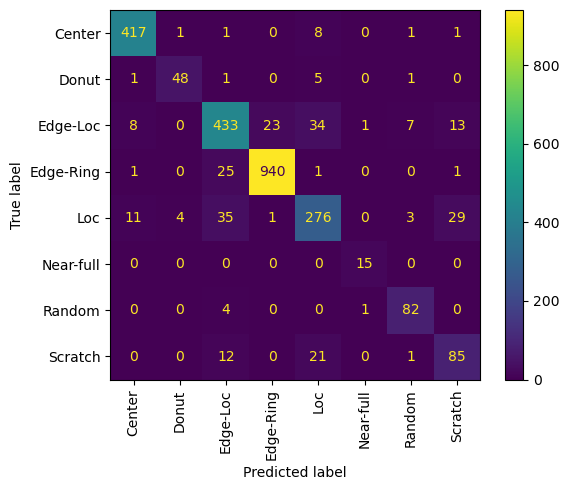

9min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
%%timeit -r 1 -n 1

# データのインポート
df = pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = matching_rows / len(y_test_df_by_failure_type)
        print(f"不良タイプ {failure_type} の正答率：{accuracies[failure_type] * 100:.2f}%")
    
    average_accuracy = sum(accuracies.values()) / len(accuracies)

print(f"平均精度：{average_accuracy * 100:.2f}%")

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_df, user_result_df, xticks_rotation="vertical")
plt.show()